In [1]:
%config Completer.use_jedi = False

# 2.1 서론
### 2.1.1. Model Context

- pymc3 에서는, `Model` 객체 내에서 원하는 모든 변수를 처리함. 

In [2]:
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1.0)
    data_generator = pm.Poisson('data_generator', parameter)

- `with` 문을 통해 동일한 model 오브젝트 내에서 작업 가능

In [4]:
with model:
    data_plus_one = data_generator + 1

In [5]:
parameter.tag.test_value

array(0.69314718)

- 이전에 사용한 것과 동일한 이름으로 다른 모델 객체를 생성하려면 이전 코드만 다시 실행하면 됨

In [6]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

- 모델 이름만 자유롭게 지정하면 다른 모델 생성 가능

In [7]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

### 2.1.2. PyMC3 Variables
- 모든 pymc3 변수에는 초기값(테스트용)이 있음

In [8]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


- `test_value`는 모델 시작지점에서만 사용됨(다른 시작이 지정되지 않는 경우). 값도 변경 가능

In [9]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1.0, testval=0.5)
    
parameter.tag.test_value

array(0.5)

- pymc3는 stochastic과 deterministic의 두 유형의 프로그래밍 변수와 관련있음


### 2.1.3. 확률 변수 초기화
- stochastic, 또는 random 변수를 초기화 하려면 `name`인수와 클래스별 추가 parameter가 필요함.
    - ex) some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4) # (0, 4)는 상한 및 하한 바운더리를 나타냄
- `name` 변수는 추후 분석에서 사후확률분포를 검색할 때 사용되어 알기쉽게 설정하는게 좋음


- `shape` 변수는 여러 개의 확률변수를 생성할 때 좋음
    - beta_1 = pm.Uniform('beta_1', 0, 1)
    - beta_2 = pm.Uniform('beta_2', 0, 1)
    - 이를 아래 처럼 활용 가능
    - betas = pm.Uniform('betas', 0, 1, shape=N)


### 2.1.4. Deterministic 변수
- 간단하게 생성가능. 덧셈, 지수 같은 기본 연산은 암묵적으로 deterministic한 변수를 생성함.

In [10]:
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1.0)
    lambda_2 = pm.Exponential('lambda_2', 1.0)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)
    
new_deterministic_variable = lambda_1 + lambda_2

- 그러나 샘플링으로 deterministic 변수를 실제로 추적하려면 생성자와 함께 명명된 결정적 변수로 명시적으로 정의하여야 함.
- 결정적 변수의 사용은 이전 장의 텍스트 데이터에서 볼 수 있었음.
$$\lambda=\begin{cases}\lambda_1 & if~~t<\tau\\\lambda_2 & if~~t \ge \tau\end{cases}$$

In [11]:
import numpy as np

n_data_points = 5 # 챕터 1에는 ~70개 정도 있었음
idx = np.arange(n_data_points)

with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

- lambda_는 tau, labmda_1, lambda_2 값이 알려진 경우 명백히 값을 알 수 있으므로 결정론적 변수임.
- 결정론적 변수 내에서 전달된 확률적 변수는 스칼라 또는 numpy 배열처럼 작동함. 차원만 맞으면 모든 작업 가능함.


- 그러나, 계산은 Theano의 tensor 작동 방식으로 계산됨.


### 2.1.5. Theano
- pymc3의 고비용 작업들은 대부분 theano에서 실행됨. theano의 표기법은 넘파이와 매우 비슷하며, numpy의 많은 계산 요소를 지원함.
- numpy는 계산을 직접 실행하지만 theano는 연산 수행하는 것을 추적하는 '계산 그래프'를 작성함.
- theano 안에서 `eval()`을 수행할 때만 계산 비용이 소모됨.
- 컴퓨팅 그래프가 구축되면 모든 종류의 optimize를 수행하고, gradient 계산 및 C로 컴파일 및 GPU에서 수행되도록 컴파일 가능함.
- 즉, theano를 적절히 사용하면 더 pymc3를 잘 쓸 수 있는 것

In [12]:
import theano.tensor as tt

with pm.Model() as thano_test:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1-p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical('assignment', p)

### 2.1.6. 모델에 관측 포함하기
- 아래 그림에서 $\lambda_1$에 대한 사전확률분포는 어떻게 생겼는가? 라는 질문을 하고 답 가능.

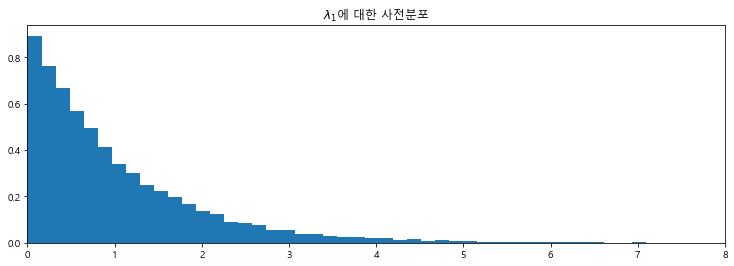

In [13]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib

figsize(12.5, 4)
matplotlib.rc('font', family='Malgun Gothic')

samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("$\lambda_1$에 대한 사전분포")
plt.xlim(0, 8);

- 모델의 관측값을 포함하는 작업을 1장의 개념 틀에 맞추기 위해 P(A)를 구체적으로 지정함. 다음 목표는 데이터/증거/관측치 X를 모델에 포함시키는 것.


- pymc3의 스토캐스틱 변수는 `observed` 키워드 인수가 있음. `observed` 역할은 매우 간단함(변수의 현재 값을 주어진 numpy array나 pandas dataframe으로 변환함)

In [14]:
data = np.array([10, 5])

with model:
    fixed_variable = pm.Poisson('fxd', 1, observed=data)

fixed_variable.tag.test_value

array([10,  5], dtype=int64)

- 데이터를 모델에 포함시키는 방법. 확률변수가 고정된 값을 갖도록 초기화 하는 것.
- 따라서, 문자 메세지 예제를 완성시키려면 pymc3 변수 ovservations를 observed dataset으로 바로 잡아야 함.

In [15]:
# fake data
data = np.array([10, 25, 15, 20, 35])

with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
    
print(obs.tag.test_value)

[10 25 15 20 35]
